<a href="https://colab.research.google.com/github/Nikelroid/DeepLearning_Project/blob/main/Phase-3/Phase3_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data onto the disk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/My Drive

/content/drive/My Drive


In [ ]:
# !ls drive/My\ Drive/

In [ ]:
# !cp train_ende.zip .
# !cp test.zip .

In [ ]:
#!git clone https://github.com/XL2248/MSCTD

In [ ]:
'''
!cp MSCTD/MSCTD_data/ende/english_*.txt .
!cp MSCTD/MSCTD_data/ende/image_index_*.txt .
!cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

import os
import shutil

for file in os.listdir('MSCTD/MSCTD_data/ende'):
    if file.startswith('english_'):
        shutil.copy('MSCTD/MSCTD_data/ende/' + file, file)
    if file.startswith('image_index_'):
        shutil.copy('MSCTD/MSCTD_data/ende/' + file, file)
    if file.startswith('sentiment_'):
        shutil.copy('MSCTD/MSCTD_data/ende/' + file, file)
'''

In [ ]:
#!pip install --upgrade --no-cache-dir gdown
#!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
#!gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W

In [ ]:
%cd drive/MyDrive/dataset/train

In [ ]:
!ls

In [ ]:
!unzip train_ende.zip


In [ ]:
'''
%%bash
for x in *.zip
do
  unzip -qq $x
done
'''

In [ ]:
# !mkdir dataset
# !cd dataset; mkdir train test dev
'''
os.makedirs('dataset', exist_ok=True)
os.makedirs('dataset/train', exist_ok=True)
os.makedirs('dataset/test', exist_ok=True)
os.makedirs('dataset/dev', exist_ok=True)
'''

In [ ]:
# !mv *train* dataset/train
# !mv *test* dataset/test
# !mv *dev* dataset/dev
'''
for file in os.listdir():
    if 'train' in file:
        shutil.move(file, 'dataset/train')
    if 'test' in file:
        shutil.move(file, 'dataset/test')
    if 'dev' in file:
        shutil.move(file, 'dataset/dev')
'''

# Dataset and Dataloader

In [10]:
!pip install -q mtcnn

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from mtcnn.mtcnn import MTCNN
import linecache

In [6]:
class MSCTD_Dataset (Dataset):
  def __init__(self, dataset_dir, images_dir, conversation_dir, texts, sentiments,
                transform=None, preprocess_func=None, pad_idx=None, max_len=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.sentiment_path = self.dataset_path / sentiments
    self.text_path = self.dataset_path / texts
    self.conversations_path = self.dataset_path / conversation_dir

    self.transform = transform

    self.preprocess_func = preprocess_func
    self.pad_idx = pad_idx
    self.max_len = max_len

    with open(self.text_path, 'r') as f:
        self.texts = f.read().splitlines()

    with open(self.sentiment_path, 'r') as f:
        self.sentiments = np.array(f.read().splitlines()).astype("int32")

    with open(self.conversations_path, 'r') as f:
        self.conversations = np.array(f.read().splitlines())
    
  def __len__(self):
        return len(self.sentiments)

  def __getitem__(self, idx):
        img_path = self.images_path / f'{idx}.jpg'
        image = Image.open(img_path)
        # image = read_image(str(img_path))
        if self.transform:
            image = self.transform(image)
       
        text = self.texts[idx].strip()

        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        
        sentiment = self.sentiments[idx]

        data_dict = {"text":text,
                     "image":image,
                     "sentiment":sentiment}
        return data_dict

In [7]:
class Final_Dataset (MSCTD_Dataset):
  def __init__(self, dataset_dir, images_dir, conversation_dir, texts, sentiments,
               preprocess_func=None, pad_idx=None, max_len=None, transform=None):

    super().__init__(dataset_dir, images_dir, conversation_dir, texts, sentiments, transform)
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.sentiment_path = self.dataset_path / sentiments
    self.text_path = self.dataset_path / texts
    self.conversations_path = self.dataset_path / conversation_dir
    self.transform = transform
    self.preprocess_func = preprocess_func
    self.pad_idx = pad_idx
    self.max_len = max_len

    with open(self.sentiment_path, 'r') as f:
      self.length = len(f.readlines())

    with open(self.text_path, 'r') as f:
        self.texts = f.read().splitlines()

    with open(self.sentiment_path, 'r') as f:
        self.sentiments = np.array(f.read().splitlines()).astype("int32")
    
    with open(self.conversations_path, 'r') as f:
        self.conversations = np.array(f.read().splitlines())
    
  def __len__(self):
        return self.length

  def __getitem__(self, idx):
        text = self.texts[idx]
        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        labels = self.sentiments[idx]
        img_path = self.images_path / f'{idx}.jpg'
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        sentiment = self.sentiments[idx]
        return text,image,sentiment

In [ ]:
!pip install pyenchant

In [ ]:
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import enchant
english_dict = enchant.Dict("en_US")

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

In [ ]:
NUM = '<NUM>'
UNK = '<UNK>'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def sent_preprocess(sent, lower=True, remove_punct=True, remove_stopwords=True,
                    lemmatize=True, handle_nums=True, handle_unknowns=True):
    if lower:
        sent = sent.lower()
    
    if remove_punct:
        sent = sent.translate(str.maketrans('', '', string.punctuation))
    
    word_tokens = word_tokenize(sent)

    if remove_stopwords:
        word_tokens = [w for w in word_tokens if not w in stop_words]

    if lemmatize:
        word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]

    if handle_nums:
        
        def is_number(s):
            if s.isdigit():
                return True
            if s[:-2].isdigit():
                if s[-2:] == 'th' or s[-2:] == 'st' or s[-2:] == 'nd' or s[-2:] == 'rd':
                    return True
            return False

        word_tokens = [NUM if is_number(w) else w for w in word_tokens]

    if handle_unknowns:
        word_tokens = [w if english_dict.check(w) else UNK for w in word_tokens]

    return word_tokens

# Model

### Bert Congfiguration

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.6 MB/s eta 0:00:00


In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel, AutoModel, BertForSequenceClassification
from transformers import AdamW

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# general config
MAX_LEN = 30

TRAIN_BATCH_SIZE = 512
VALID_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512

EPOCHS = 4
LEARNING_RATE = 5e-5

MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
config = BertConfig.from_pretrained(MODEL_NAME)

In [ ]:
def bert_preprocess(text):
    return tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        padding='max_length',
        return_tensors='pt',
    )

In [ ]:
# change this if needed
transform = T.Compose([T.ToTensor()])

trainset = MSCTD_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt', preprocess_func=bert_preprocess, transform=transform)
devset = MSCTD_Dataset('dataset/dev', 'dev', 'image_index_dev.txt', 'english_dev.txt', 'sentiment_dev.txt', preprocess_func=bert_preprocess, transform=transform)
testset = MSCTD_Dataset('dataset/test', 'test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt', preprocess_func=bert_preprocess, transform=transform)

In [ ]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=False)
dev_loader = DataLoader(devset, batch_size=32, shuffle=False)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

#Section A:
**In this section we aim to use vector representations of our dataset, concatenate them and make use of a fully connected model to take the best out of them**

##Step 1:<br/>Load models trained in earlier phases

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])     
def bert_preprocess(text):
    return tokenizer.encode_plus(
        text,
        max_length= MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        padding='max_length',
        return_tensors='pt',
    )
train_dataset = Final_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt',preprocess_func=bert_preprocess,transform=transform)
dev_dataset = Final_Dataset('dataset/dev', 'dev', 'image_index_dev.txt', 'english_dev.txt', 'sentiment_dev.txt',preprocess_func=bert_preprocess,transform=transform)
test_dataset = Final_Dataset('dataset/test', 'test', 'image_index_test.txt', 'english_test.txt', 'sentiment_test.txt',preprocess_func=bert_preprocess,transform=transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

In [ ]:
#!pip install --upgrade --no-cache-dir gdown
#!gdown 11caq-CNLP6_V3106zj0zAkFyYPAjyjyw

!pip install transformers
from transformers import BertForSequenceClassification

def load_pretrained_bert(name='models/bert_model.pt'):
    model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
    ).to(device)
    model.load_state_dict(torch.load(name))
    model.classifier = nn.Sequential()
    return model

In [ ]:
#!pip install --upgrade --no-cache-dir gdown
#!gdown 1EfyDFNxAHGjvnLPRbP0SfnkV9g33-CFJ

from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

def load_pretrained_image(name = 'models/scene_modal_en.pth'):
    class lastLayer(nn.Module):
      def __init__(self, pretrained):
          super(lastLayer, self).__init__()
          self.pretrained = pretrained
          self.last = nn.Sequential(
              nn.Dropout(p = 0.2,inplace=True),
              nn.Linear(1408, 90),
              nn.Dropout(p = 0.3,inplace=True),
              nn.Linear(90, 30),
              nn.Dropout(p = 0.1,inplace=True),
              nn.Linear(30, 3),
              )
      
      def forward(self, x):
          x = self.pretrained(x)
          x = self.last(x)
          return x

    image_model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    image_model.classifier = nn.Sequential()
    image_model = lastLayer(image_model).to(device)
    image_model.load_state_dict(torch.load("models/scene_modal_en.pth"))
    image_model.last = nn.Sequential()
    return image_model

In [ ]:
image_model = load_pretrained_image()
text_model = load_pretrained_bert()


##Step 2:<br/>Get Embedded vectors of our data using previous phases' models.

In [ ]:
#!mkdir dataset/train/cated_data

In [ ]:
'''
import tqdm
import pickle

vectors = []
labels = []
with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
      with torch.no_grad():  
        for i, m in pbar:
            data_i,image_i, y = m
            (input_ids, attention_mask, token_type_ids) = data_i.values()
            input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
            y = y.to(device)
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)
            output = text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            rep_text = output.logits
            y = y.to(device)
            image_i = image_i.to(device)
            rep_image = image_model(image_i)
            rep = torch.cat((rep_text,rep_image),dim=1)
            print(rep.size())
            print(y.size())
            torch.save(y, "dataset/train/cated_data/labels_"+str(i)+".pt") 
            torch.save(rep, "dataset/train/cated_data/vectors_"+str(i)+".pt") 
'''

In [ ]:
#!mkdir dataset/test/cated_data

In [ ]:
'''
import tqdm
import pickle

vectors = []
labels = []
with tqdm.tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
      with torch.no_grad():  
        for i, m in pbar:
            data_i,image_i, y = m
            (input_ids, attention_mask, token_type_ids) = data_i.values()
            input_ids, attention_mask, token_type_ids = input_ids.to(device), attention_mask.to(device), token_type_ids.to(device)
            y = y.to(device)
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)
            output = text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            rep_text = output.logits
            y = y.to(device)
            image_i = image_i.to(device)
            rep_image = image_model(image_i)
            rep = torch.cat((rep_text,rep_image),dim=1)
            print(rep.size())
            print(y.size())
            torch.save(y, "dataset/test/cated_data/labels_"+str(i)+".pt") 
            torch.save(rep, "dataset/test/cated_data/vectors_"+str(i)+".pt") 
'''

In [ ]:
image_lenght = int(len([name for name in os.listdir("dataset/train/cated_data") if os.path.isfile(os.path.join("dataset/train/cated_data", name))])/2)
data_train = torch.load("dataset/train/cated_data/vectors_"+str(0)+".pt")
labels_train = torch.load("dataset/train/cated_data/labels_"+str(0)+".pt")
for i in range(1,image_lenght):
  t = torch.load("dataset/train/cated_data/vectors_"+str(i)+".pt")
  lb = torch.load("dataset/train/cated_data/labels_"+str(i)+".pt")
  data_train = torch.cat((data_train,t),dim=0)
  labels_train = torch.cat((labels_train,lb),dim=0)

In [ ]:
data_train.size()

torch.Size([20240, 2176])

In [ ]:
labels_train.size()

torch.Size([20240])

In [ ]:
image_lenght = int(len([name for name in os.listdir("dataset/test/cated_data") if os.path.isfile(os.path.join("dataset/test/cated_data", name))])/2)
data_test = torch.load("dataset/test/cated_data/vectors_"+str(0)+".pt")
labels_test = torch.load("dataset/test/cated_data/labels_"+str(0)+".pt")
for i in range(1,image_lenght):
  t = torch.load("dataset/test/cated_data/vectors_"+str(i)+".pt")
  lb = torch.load("dataset/test/cated_data/labels_"+str(i)+".pt")
  data_test = torch.cat((data_test,t),dim=0)
  labels_test = torch.cat((labels_test,lb),dim=0)

In [ ]:
data_test.size()

torch.Size([5067, 2176])

In [ ]:
labels_test

tensor([1, 1, 2,  ..., 2, 1, 2], device='cuda:0', dtype=torch.int32)

##Step 3:<br/>Define Model Architecture

In [ ]:
import torch.nn.functional as F
class MultiModalModel(nn.Module):
        def __init__(self,num_input,num_classes=3):
          super(MultiModalModel,self).__init__()
          hidden_1 = num_input//2
          self.fc1 = nn.Linear(num_input, hidden_1)
          self.fc2 = nn.Linear(hidden_1, num_classes)
          self.droput = nn.Dropout(0.1)

        def forward(self,x):
          x = F.relu(self.fc1(x))
          x = self.droput(x)
          x = self.fc2(x)
          return x

In [ ]:
modalmodel = MultiModalModel(data_train.size()[1]).to(device)

## Training

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import tqdm

def one_epoch(model, vector,truth, criterion, optimizer=None, train=True,batch_size = 64):
    total_loss = 0
    N = len(truth)
    Y = []
    Y_pred = []
    if train:
        model.train()
    else:
        model.eval()
    for i in (range(N//batch_size + 1)):
        vec = vector[i*batch_size:min((i+1)*batch_size,N)]
        y = truth[i*batch_size:min((i+1)*batch_size,N)]
        
        if train:
            optimizer.zero_grad()
        vec = vec.to(device)
        y = y.long().to(device)
        p = model(vec)
        loss = criterion(p, y.long())
        total_loss += loss.item() * len(y)
        if train:
            loss.backward()
            optimizer.step()
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [ ]:
def train_model(model, train,test, num_epochs, criterion, optimizer, model_name='pytroch-model', scheduler=None,batch_size=64):
    train_loader, train_labels = train
    test_loader, test_labels = test
    min_val_acc = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        result = one_epoch(model, train_loader,train_labels, criterion, optimizer, train=True,batch_size=batch_size)
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(model, test_loader,test_labels, criterion, train=False,batch_size=batch_size)
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print()
        print(f'Train Accuracy : {train_acc*100.:2f}% , Train Loss : {train_loss:4f}')
        print(f'Valid Accuracy : {val_acc*100.:2f}% , Valid Loss : {val_loss:4f}')

        if val_acc > min_val_acc:
            min_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}.pt')

        if scheduler:
            scheduler.step(val_loss)

    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss history of training and Val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and Val sets')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(f'{model_name}.pt'))
    return model, min_val_loss

In [ ]:
average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

In [ ]:
# Training Configuration
LEARNING_RATE = 1e-5
EPOCH = 30
BATCH_SIZE = 64
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modalmodel.parameters()), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, factor=0.5)
criterion = nn.CrossEntropyLoss()
modalmodel, min_val_loss = train_model(modalmodel, (data_train,labels_train),(data_test,labels_test),EPOCH, criterion, optimizer, model_name='multi_modal', scheduler=scheduler,batch_size =BATCH_SIZE)

## Evaluation

In [ ]:
def eval_model(model, loader, metrics=metrics, set_name='Test', plot_confusion_matrix=True):
    test_loader,test_labels = loader
    results = one_epoch(modalmodel, test_loader,test_labels, criterion, train=False,batch_size=64)
    disp = ConfusionMatrixDisplay(results.pop('confusion_matrix'))
    if plot_confusion_matrix:
        disp.plot()
    return results

{'loss': 1.0308159757512125,
 'accuracy': 0.5109532267613973,
 'precision': 0.49459412570910005,
 'recall': 0.49214243052451795,
 'f1': 0.4865680397937809}

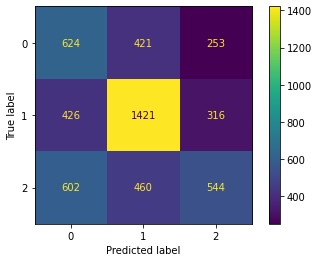

In [ ]:
eval_model(modalmodel, (data_test,labels_test))

#Section B:
**Now we are to use a transformer model as a backbone**

##essential imports

In [3]:
!pip install -q transformers

In [4]:
from transformers import AutoTokenizer, VisualBertForVisualReasoning
from transformers import BertConfig, BertTokenizer
from transformers import BertModel, AutoModel, BertForSequenceClassification
from transformers import AdamW
import torch
from torch.nn import BCEWithLogitsLoss as logit_bce

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


##Configurations

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [96]:
# general config
VIS_EMB_DIM=1408
TXT_EMB_DIM=768

TRAIN_DATA_SIZE=40
TEST_DATA_SIZE=10

TRAIN_BATCH_SIZE = 240
TEST_BATCH_SIZE = 240

In [104]:
model = VisualBertForVisualReasoning.from_pretrained("uclanlp/visualbert-nlvr2",
                                                    num_labels = 3,
                                                    output_attentions=False,
                                                    output_hidden_states=False,
                                                    visual_embedding_dim = VIS_EMB_DIM,
                                                    ignore_mismatched_sizes=True)

model = model.to(device)

Some weights of VisualBertForVisualReasoning were not initialized from the model checkpoint at uclanlp/visualbert-nlvr2 and are newly initialized because the shapes did not match:
- visual_bert.embeddings.visual_projection.weight: found shape torch.Size([768, 1024]) in the checkpoint and torch.Size([768, 1408]) in the model instantiated
- cls.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- cls.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Preparing suitable datasets for the process
**Since we are dealing with a somewhat different data from the original data we used to work on; we now need a dataset compatible with the new data**

In [12]:
class Final_Emb_Dataset (Dataset):
  def __init__(self, dataset_dir, visual_embedded_dir, visual_file_len, transform=None):

    self.visual_embedded_path = dataset_dir +"/"+ visual_embedded_dir
    self.transform = transform

    self.sentiments = torch.load(self.visual_embedded_path+"/labels_0.pt")
    self.vectors = torch.load(self.visual_embedded_path+"/vectors_0.pt")
    for i in range(1,visual_file_len):
      self.sentiments = torch.cat((self.sentiments,torch.load(self.visual_embedded_path+f"/labels_{i}.pt")))
      self.vectors = torch.cat((self.vectors,torch.load(self.visual_embedded_path+f"/vectors_{i}.pt")))

    self.length= self.vectors.size()[0]

    
  def __len__(self):
        return self.length

  def __getitem__(self, idx):
        sentiment = self.sentiments[idx]
        image = self.vectors[idx,-VIS_EMB_DIM:]
        text = self.vectors[idx,:TXT_EMB_DIM]
        return text,image,sentiment

In [150]:
# def bert_preprocess(text):
#     return tokenizer.encode_plus(
#         text,
#         max_length=MAX_LEN,
#         truncation=True,
#         add_special_tokens=True,
#         return_token_type_ids=True,
#         return_attention_mask=True,
#         padding='max_length',
#         return_tensors='pt',
#     )

In [13]:
transform = T.Compose([T.ToTensor()])

trainset = Final_Emb_Dataset('dataset/train','cated_data', TRAIN_DATA_SIZE,transform=transform)
testset = Final_Emb_Dataset('dataset/test', 'cated_data', TEST_DATA_SIZE,transform=transform)

In [97]:
train_loader = DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, batch_size=TEST_BATCH_SIZE, shuffle=False)

##Training

In [15]:
average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}


In [16]:
def onehot(y):
  out = torch.zeros((y.size()[0],3),device=device)
  for i,index in enumerate(y):
    out[i,index.item()] = 1
  return out

In [105]:
import tqdm

def one_epoch(model, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train', metrics=None):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    Accs = []
    if train:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader), total=len(loader)) as pbar:
        for i, data_i in pbar:
            if train:
                optimizer.zero_grad()

            text, image, y = data_i[0], data_i[1], data_i[2]

            inputs_embeds = text.unsqueeze(1).to(torch.float)
            visual_embeds = image.unsqueeze(1)
            visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long, device=device)
            visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float, device= device)
            labels = y.unsqueeze(0).to(torch.long)
            inputs=(
                {
                    "inputs_embeds" : inputs_embeds,
                    "visual_embeds": visual_embeds,
                    "visual_token_type_ids": visual_token_type_ids,
                    "visual_attention_mask": visual_attention_mask,
                }
            )

            outputs = model(**inputs, labels=labels)
            #loss = outputs.loss
            scores = outputs.logits
            loss = criterion(scores, onehot(y.long()))
            

            total_loss += loss.item() * len(y)

            if train:
                loss.backward()
                optimizer.step()
                

            y_pred = scores.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

            Accs.append(np.count_nonzero(y_pred.cpu().numpy() == y.cpu().numpy())/len(y))
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}, acc : {sum(Accs)/len(Accs)*100:.4f}%')


    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [99]:
def train_model(model, dataloaders, num_epochs, criterion, optimizer, model_name='visualbert-model', scheduler=None):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf
    max_val_acc = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        result = one_epoch(model, train_loader, criterion, optimizer, epoch, train=True, set_name='Train')
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(model, val_loader, criterion, epoch=epoch, train=False, set_name='Validation')
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print('\n', '-' * 60)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            torch.save(model.state_dict(), f'models/{model_name}.pt')

        if scheduler:
            scheduler.step(val_loss)

    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('loss history of training and val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and val sets')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(f'models/{model_name}.pt'))
    return model, min_val_loss

In [106]:
LEARNING_RATE = 1e-4
EPSILON = 5e-8
EPOCHS = 5

In [107]:
optimizer = torch.optim.AdamW(model.parameters(),lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, factor=0.5)
criterion = logit_bce()

0: Train Loss: 5.829e-01, acc : 51.4902%: 100%|██████████| 85/85 [00:11<00:00,  7.57it/s]


Accuracy of Train set: 0.5146245059288538


0: Validation Loss: 6.242e-01, acc : 44.8064%: 100%|██████████| 22/22 [00:00<00:00, 26.94it/s]


Accuracy of Validation set: 0.44977304124728634

 ------------------------------------------------------------


1: Train Loss: 5.656e-01, acc : 53.7059%: 100%|██████████| 85/85 [00:11<00:00,  7.50it/s]


Accuracy of Train set: 0.5374505928853754


1: Validation Loss: 6.375e-01, acc : 48.3186%: 100%|██████████| 22/22 [00:00<00:00, 26.23it/s]


Accuracy of Validation set: 0.47858693507006117

 ------------------------------------------------------------


2: Train Loss: 5.494e-01, acc : 56.7108%: 100%|██████████| 85/85 [00:11<00:00,  7.45it/s]


Accuracy of Train set: 0.5670454545454545


2: Validation Loss: 6.029e-01, acc : 51.4604%: 100%|██████████| 22/22 [00:00<00:00, 26.60it/s]


Accuracy of Validation set: 0.5097690941385435

 ------------------------------------------------------------


3: Train Loss: 5.451e-01, acc : 57.2059%: 100%|██████████| 85/85 [00:11<00:00,  7.20it/s]


Accuracy of Train set: 0.5714426877470355


3: Validation Loss: 5.990e-01, acc : 53.0324%: 100%|██████████| 22/22 [00:00<00:00, 23.76it/s]


Accuracy of Validation set: 0.5261495954213539

 ------------------------------------------------------------


4: Train Loss: 5.424e-01, acc : 57.8186%: 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]


Accuracy of Train set: 0.5784090909090909


4: Validation Loss: 6.131e-01, acc : 51.0248%: 100%|██████████| 22/22 [00:00<00:00, 26.82it/s]


Accuracy of Validation set: 0.5052299190842707

 ------------------------------------------------------------


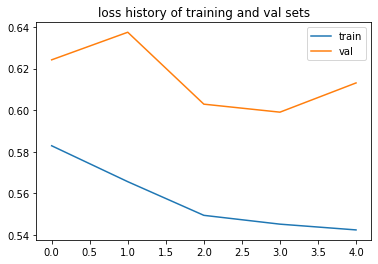

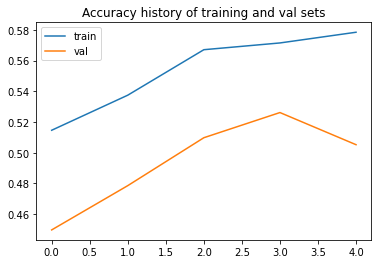

In [108]:
model, min_val_loss = train_model(model, 
                                  (train_loader, test_loader), 
                                  EPOCHS, 
                                  criterion, 
                                  optimizer, 
                                  model_name='visualbert_cnn_alt_second', 
                                  scheduler=None)

##Evaluation

In [69]:
def eval_model(model, loader, metrics=metrics, set_name='Test', plot_confusion_matrix=True):
    results = one_epoch(model, loader, criterion, train=False, set_name=set_name, metrics=metrics)
    disp = ConfusionMatrixDisplay(results.pop('confusion_matrix'))
    if plot_confusion_matrix:
        disp.plot()
    return results

: Test Loss: 5.847e-01, acc : 53.1460%: 100%|██████████| 22/22 [00:01<00:00, 11.31it/s]


Accuracy of Test set: 0.5273337280442076


{'loss': 0.5847306788285291,
 'accuracy': 0.5273337280442076,
 'precision': 0.4995780017875528,
 'recall': 0.4943013850730122,
 'f1': 0.4935012725034298}

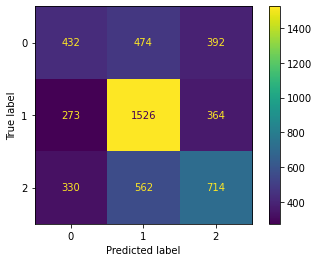

In [110]:
model.load_state_dict(torch.load('models/visualbert_cnn_alt.pt'))
eval_model(model, test_loader)